# TIME SERIES ANALYSIS (ARIMA / SARIMAX)
Land Temperature Prediction with SARIMAX Model


---



#### INTRODUCTION
This project focuses on Time Series Analysis to predict average temperatures using ARIMA and SARIMAX models. The dataset contains temperature records from various cities across several years. The main goal is to analyze historical temperature patterns and evaluate how well ARIMA and SARIMAX models can capture these trends. Through this analysis, we aim to understand temperature changes over time and showcase the practical use of these models for accurate time series forecasting in real-world applications.

In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hide Warning Messages
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load Data
temp = pd.read_csv('GlobalLandTemperaturesByCity.csv')
temp.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### DATA PREPROCESSING
To prepare the dataset for analysis, a structured data preprocessing approach was applied. The dataset initially included data from many cities, so three random cities were selected for simplicity. Only the Date and Average Temperature columns were kept, while rows with missing temperature values were removed to maintain accuracy. Duplicate records for the same date were handled by calculating the mean temperature for that day. Year and Month were extracted from the Date column to help analyze seasonal and yearly trends. To reduce the dataset size, specific years, such as very early ones or outliers, were excluded. Finally, the data was sorted by date, setting the Date column as the index, ensuring the dataset was ready for time series analysis.

In [ ]:
# Sampling Cities
temp = temp[temp['Country']=='United States']
cities = ['New York', 'Los Angeles', 'San Francisco']
temp = temp[temp['City'].isin(cities)]

In [ ]:
# Feature Selection
temp = temp[['dt','AverageTemperature']]
temp.columns=['Date', 'AvgTemp']

In [ ]:
# Missing Values
temp.isnull().sum()

,0
Date,0
AvgTemp,120


In [ ]:
# Remove Missing Values
temp.dropna(inplace=True)

In [ ]:
# Convert Date Format
temp['Date'] = pd.to_datetime(temp['Date'])

# Group by Date
temp = temp.groupby('Date').mean()
temp.head(3)

,AvgTemp
Date,
1743-11-01,3.264
1744-04-01,9.788
1744-05-01,15.708


In [ ]:
# Extract Month and Year
temp['year'] = temp.index.year
temp['month'] = temp.index.month
temp.head(3)

,AvgTemp,year,month
Date,,,
1743-11-01,3.264,1743,11
1744-04-01,9.788,1744,4
1744-05-01,15.708,1744,5


In [ ]:
# Exclude Years Before 1750 and the Year 2013
temp = temp[(temp['year'] >= 1750) & (temp['year'] != 2013)]
temp.shape

(3097, 3)

In [ ]:
# Sort by Index
temp.sort_index(inplace=True)

#### CHECKING DATA SEASONALITY
Seasonality analysis helps identify recurring temperature patterns, providing insights into monthly variations and long-term trends. To achieve this, the dataset is reorganized using a pivot table. Monthly average temperatures were calculated (using months as the index) across multiple years (as columns). This allowed for a clear visualization of temperature trends and variations for each month over the years.

Text(0, 0.5, 'Temperatures')

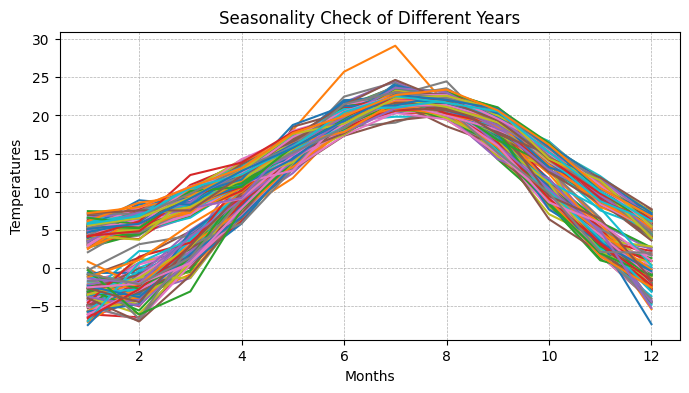

In [ ]:
# Check Seasonality of the Data
pivot = temp.pivot_table(values='AvgTemp',index="month", columns='year')
plt.figure(figsize=(8,4))
plt.plot(pivot)
plt.legend().remove()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Seasonality Check of Different Years', fontsize=12)
plt.xlabel('Months', fontsize=10)
plt.ylabel('Temperatures', fontsize=10)



> This graph clearly shows seasonality in the data. Temperatures follow a consistent pattern, rising in the middle of the year (summer) and dropping towards the start and end of the year (winter). The similar trends across multiple years confirm the presence of seasonal variations in the dataset.



#### CHECKING DATA STATIONARITY
Stationarity is essential for time series modeling, as models like ARIMA and SARIMAX require the data's statistical properties (mean, variance, and autocorrelation) to remain constant over time for reliable predictions. The Average Temperature column was plotted against time to visually examine trends, seasonal patterns, and variability in the dataset.

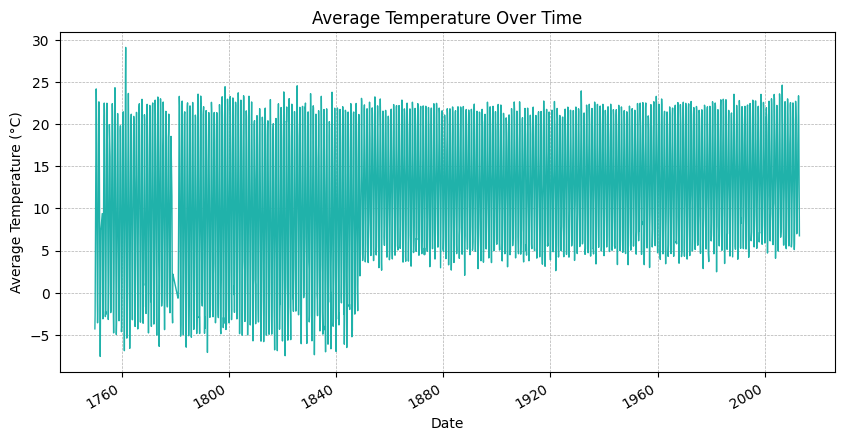

In [ ]:
# Stationarity Checking
temp['AvgTemp'].plot(figsize=(10, 5), linewidth=1, color='lightseagreen')
plt.title('Average Temperature Over Time', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Average Temperature (°C)', fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



> The plotted time series reveals potential non-stationarity due to visible fluctuations and a lack of uniformity in the data's behavior over time.



#### AUGMENTED DICKEY-FULLER TEST
The Augmented Dickey-Fuller (ADF) test is used to determine if the data is stationary, which is essential for time series modeling techniques like ARIMA and SARIMAX. Stationarity ensures that the model can accurately learn patterns in the data.
The null hypothesis (H0) assumes the time series is non-stationary, and the alternative hypothesis (H1) assumes stationarity. A p-value below 0.05 indicates that the null hypothesis can be rejected, suggesting the data is stationary.

In [ ]:
# Augmented Dickey-Fuller (ADF) Test
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistics', 'p-value', 'Lags', 'Number of Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis. The data is stationary')
    else:
        print('Weak evidence against null hypothesis. The data is non-stationary')

adfuller_test(temp['AvgTemp'])

ADF Test Statistics: -1.939901652343485
p-value: 0.3135290829481158
Lags: 28
Number of Observations: 3068
Weak evidence against null hypothesis. The data is non-stationary




> The data is non-stationary as per the ADF test result. Since stationarity is crucial for time series modeling (ARIMA, SARIMAX), we need to transform the data by applying differencing and re-run the ADF test to confirm stationarity.



#### APPLYING DIFFERENCING
To make the dataset stationary, differencing is applied to remove trends and seasonality. A new column,` SeasonalTempDiff`, is created by subtracting the temperature of the same month in the previous year (`shift(12)`) from the current month's temperature. This method effectively accounts for yearly seasonal patterns in the data.

In [ ]:
# Shift Avg Temperature
temp['SeasonalTempDiff'] = temp['AvgTemp'] - temp['AvgTemp'].shift(12)

# Drop Null Values
temp.dropna(inplace=True)
temp.head(4)

,AvgTemp,year,month,SeasonalTempDiff
Date,,,,
1751-02-01,-2.051,1751,2,2.259
1751-03-01,3.256,1751,3,5.975
1751-04-01,7.992,1751,4,5.219
1751-06-01,20.724,1751,6,11.876


After applying seasonal differencing to the dataset, a second Augmented Dickey-Fuller (ADF) Test is conducted on the `SeasonalTempDiff` column to confirm stationarity.

In [ ]:
# Augmented Dicky-Fuller (ADF) Re-Test
adfuller_test(temp['SeasonalTempDiff'])

ADF Test Statistics: -15.795428626240902
p-value: 1.0896716947175538e-28
Lags: 28
Number of Observations: 3056
Strong evidence against null hypothesis. The data is stationary


> The null hypothesis, which assumes the data is non-stationary, is strongly rejected, confirming that the data becomes stationary after differencing.


Visually examine the stationarity of the time series after applying seasonal differencing.

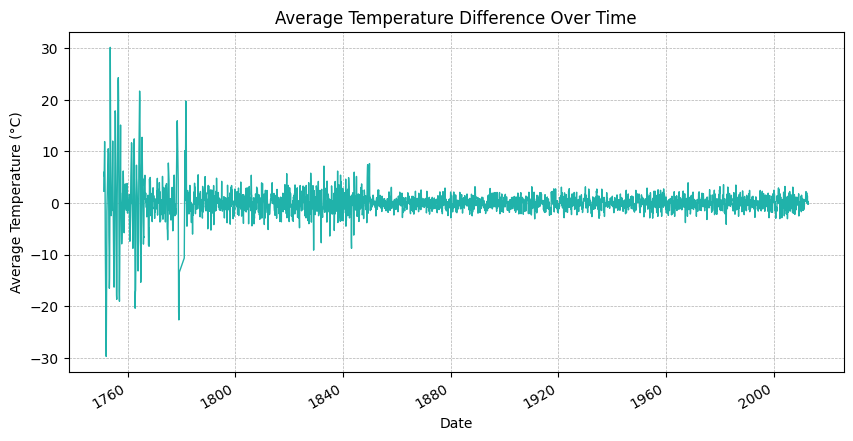

In [ ]:
# Stationary Checking
temp['SeasonalTempDiff'].plot(figsize=(10, 5), linewidth=1, color='lightseagreen')
plt.title('Average Temperature Difference Over Time', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Average Temperature (°C)', fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



> The plot shows the differenced temperature data with more consistent fluctuations over time compared to the original data. There is no clear trend or seasonality, which matches the ADF test results confirming the data is stationary.



#### AUTO CORRELATION AND PARTIAL AUTO CORRELATION
ACF and PACF method performed to analyze the patterns in the data and to identify the lag values for potential ARIMA modeling.


In [ ]:
# Import Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from matplotlib.ticker import MultipleLocator

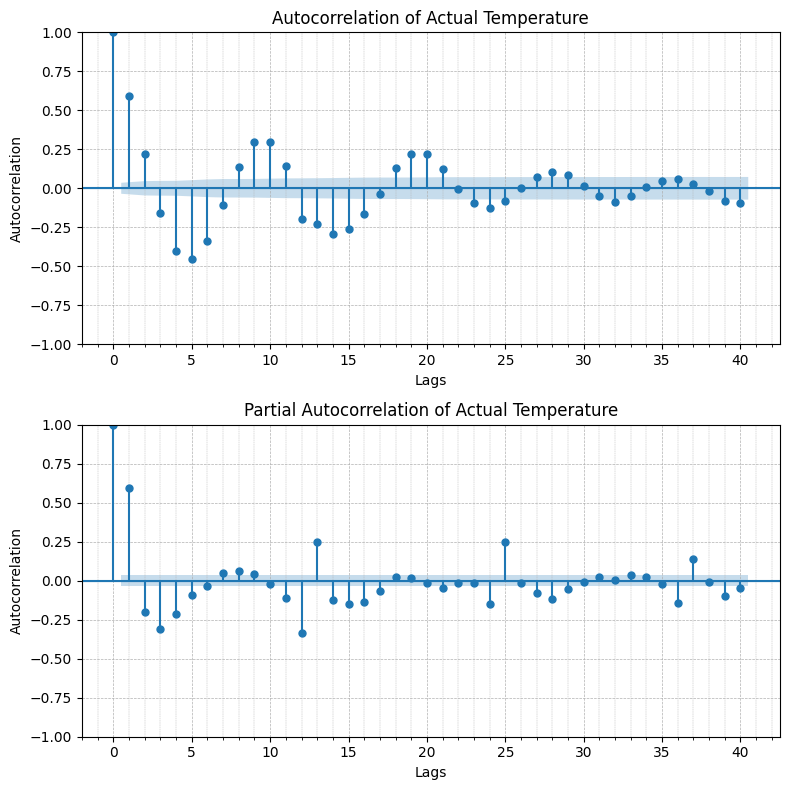

In [ ]:
# Create ACF and PACF Plot
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# ACF plot
plot_acf(temp['SeasonalTempDiff'], ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation of Actual Temperature', fontsize=12)
axes[0].set_xlabel('Lags', fontsize=10)
axes[0].set_ylabel('Autocorrelation', fontsize=10)
axes[0].grid(visible=True, which='both', linestyle='--', linewidth=0.5)
axes[0].axhline(0, linestyle='-', linewidth=0.8)  # Add a baseline
# Adding more x-axis ticks and grids for ACF
axes[0].xaxis.set_major_locator(MultipleLocator(5))  # Major ticks every 5 lags
axes[0].xaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every 1 lag
axes[0].grid(visible=True, which='minor', linestyle='--', linewidth=0.3)  # Add minor grid lines

# PACF plot
plot_pacf(temp['SeasonalTempDiff'], ax=axes[1], lags=40, alpha=0.05)
axes[1].set_title('Partial Autocorrelation of Actual Temperature', fontsize=12)
axes[1].set_xlabel('Lags', fontsize=10)
axes[1].set_ylabel('Autocorrelation', fontsize=10)
axes[1].grid(visible=True, which='both', linestyle='--', linewidth=0.5)
axes[1].axhline(0, linestyle='-', linewidth=0.8)  # Add a baseline
# Adding more x-axis ticks and grids for PACF
axes[1].xaxis.set_major_locator(MultipleLocator(5))  # Major ticks every 5 lags
axes[1].xaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every 1 lag
axes[1].grid(visible=True, which='minor', linestyle='--', linewidth=0.3)  # Add minor grid lines

# Adjust layout
plt.tight_layout()
plt.show()



> **q (Moving Average Component)**. The Autocorrelation Function (ACF) plot shows significant autocorrelations for the first 2 lags. After lag 2, the values fall within the confidence bounds (blue shaded area). Therefore, **q=2**.



> **p (Autoregressive Component)**. The Partial Autocorrelation Function (PACF) plot shows significant partial correlations for the first lag only. After lag 1, the values are within the confidence bounds. Therefore, **p=1**.


> **d (Differencing Order)**. Since differencing applied once to make the data stationary, so **d=1**.







#### ARIMA
The *AutoRegressive Integrated Moving Average* (ARIMA) model is a widely used method for time series forecasting. It is designed to analyze and predict patterns in data over time by capturing trends, seasonality, and random variations. ARIMA works by using past values and errors in the data to forecast future values, helping improve decision-making and analysis.



The dataset is split into training (first 2500 rows) and testing (remaining rows) subsets. An ARIMA model with parameters (p=1, d=1, q=2) is fitted to the training data. The model generates predictions for the test set using the forecast() method. Finally, the Root Mean Squared Error (RMSE) is calculated to evaluate the model's accuracy, with lower RMSE indicating better performance.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
# Subset the Dataframe with SeasonalTempDiff
df = temp[['AvgTemp']]
df.head(3)

,AvgTemp
Date,
1751-02-01,-2.051
1751-03-01,3.256
1751-04-01,7.992


In [ ]:
# Split Dataset
train = df[:2500]
test = df[2500:]

In [ ]:
# Fit The ARIMA Model (p, d, q)
arima=ARIMA(train, order=(1,1,2))
model=arima.fit()
pred = model.forecast(steps=len(test)).to_numpy()
np.sqrt(mean_squared_error(test, pred))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


6.173900201680464




> The RMSE for this ARIMA model was 6.17, indicating the average magnitude of prediction errors. The smaller the RMSE, the better the model's predictions align with actual values.

> This result suggests that while the ARIMA model is capturing some patterns in the data, further tuning or exploration of advanced models (SARIMAX) may be necessary for improved accuracy.



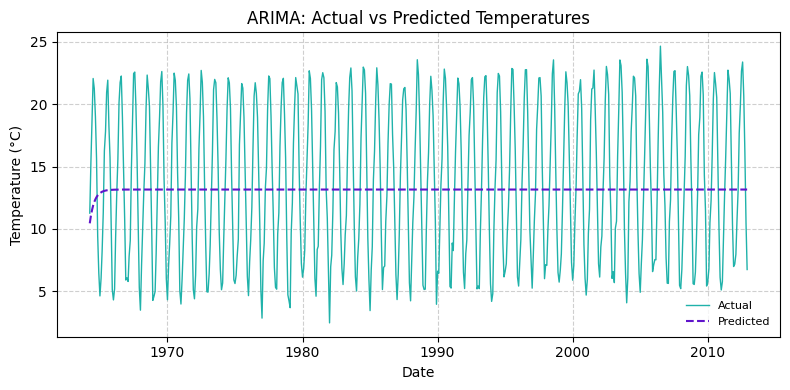

In [ ]:
# Plot ARIMA Model
plt.figure(figsize=(8, 4))
plt.plot(test.index, test, label='Actual', linewidth=1, color='lightseagreen')
plt.plot(test.index, pred, label='Predicted', linestyle='--', linewidth=1.5, color='#5F14CB')
plt.legend(loc='best', fontsize=8, edgecolor='none')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=10)
plt.title('ARIMA: Actual vs Predicted Temperatures')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



> The visual showcases the comparison between the actual temperature data (in light green) and the predictions made by the ARIMA model (in purple dashed lines). While the actual data reflects significant seasonal variations, the predicted values from ARIMA appear to be stable and fail to capture the fluctuations. This indicates that the ARIMA model may require parameter tuning or further preprocessing to enhance its forecasting accuracy for this dataset.



#### SARIMAX
The Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model is an extension of the ARIMA model designed to handle both seasonal patterns and exogenous variables. It is particularly useful when dealing with time series data that exhibit periodic trends and variations. SARIMAX enhances the forecasting accuracy by integrating seasonal patterns, making it more robust for temperature datasets where seasonality plays a significant role.

In [ ]:
# Fit SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarimax = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 1, 2, 12))
model = sarimax.fit()
pred = model.forecast(steps=len(test))
np.sqrt(mean_squared_error(test, pred))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1.523602535807335

> The RMSE value of 1.5236 indicates the accuracy of the model in forecasting temperature variations.



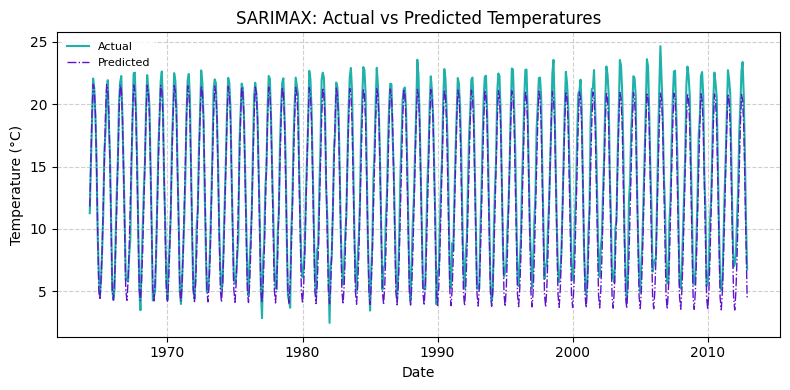

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(test.index, test, label='Actual', linewidth=1.5, color='lightseagreen')
plt.plot(test.index, pred, label='Predicted', linewidth=1, linestyle='-.', color='#5F14CB')
plt.legend(loc='best', fontsize=8, edgecolor='none')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=10)
plt.title('SARIMAX: Actual vs Predicted Temperatures')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



> The plot showcases a close alignment between the predicted values and actual values, capturing both trend and seasonality effectively.



#### FORECASTING FOR NEXT 15 YEARS USING SARIMAX
Once the SARIMAX model is fitted to the existing dataset, it can be used to generate forecasts for future periods. In this step, the model will predict temperature trends for the next 15 years, leveraging the learned trend, seasonal, and residual patterns.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


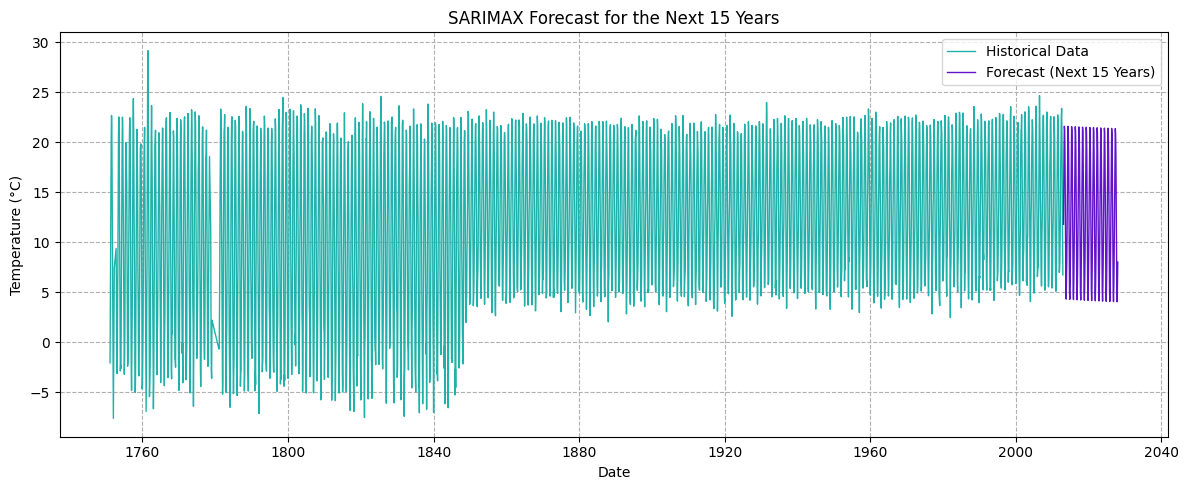

In [ ]:
# Define the number of steps for 15 years (12 months/year)
forecast_steps = 15 * 12

# Forecast for the next 15 years
future_forecast = model.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted values with corresponding future dates
future_dates = pd.date_range(start=temp.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Temp': future_forecast})
forecast_df.set_index('Date', inplace=True)

# Plot historical data and forecast
plt.figure(figsize=(12, 5))
plt.plot(temp.index, df, label='Historical Data', color='lightseagreen', linewidth=1)
plt.plot(forecast_df.index, forecast_df['Forecasted_Temp'], label='Forecast (Next 15 Years)', color='#5F14CB', linewidth=1)
plt.title('SARIMAX Forecast for the Next 15 Years', fontsize=12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=10)
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()



> A line plot with the historical data shown in *light green* and the forecasted data shown in *purple*. The model's forecast provides insights into expected temperature patterns, highlighting both seasonal variations and long-term trends.


#### CONCLUSION
The time series analysis of average temperature data using the SARIMAX model has provided valuable insights into historical trends and accurate forecasts for the next 15 years.  
- Historical temperature trends were analyzed, showing clear seasonality and patterns in the data.
- Autocorrelation and partial autocorrelation plots were used to choose the best model parameters.
- The SARIMAX model effectively handled both seasonal changes and long-term trends, achieving a lower RMSE compared to simpler ARIMA models.
- The forecast for the next 15 years predicts continued seasonal variations in temperature.

Overall, the project highlights the use of advanced time series methods for analyzing and predicting temperature data. The findings can help in better understanding climate trends and planning for sustainable development. Future improvements could include adding more climate factors or trying machine learning models for better predictions.